In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit

# plot cpu, gpu power pattern for GPGPU apps
def clean_data(data, column):
    # Iterate through the data to find negative values
    for i in range(1, len(data) - 1):
        if data[column][i] < 0:
            # Replace with the average of the previous and next values
            data.loc[i, column] = (data.loc[i-1, column] + data.loc[i+1, column]) / 2
    return data

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Clean negative values by replacing them with the average of the previous and next values
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    gpu_data = clean_data(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(4, 3))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    plt.show()
    
    # Make sure the ./fig directory exists, if not, create it
    # os.makedirs('./fig', exist_ok=True)
    # # Save the figure
    # plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    # plt.show()


def plot_uncore_freq(uncore_file):
    file_path = uncore_file  
    data = pd.read_csv(file_path)
    
    # Plot Core 0 and Core 1 Uncore Frequencies over Time
    plt.figure(figsize=(4, 3))
    
    # Plot Core 0 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 0 Uncore Frequency (GHz)'], label='Core 0 Uncore Frequency (GHz)')
    
    # Plot Core 1 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 1 Uncore Frequency (GHz)'], label='Core 1 Uncore Frequency (GHz)')
    
    # Adding labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Uncore Frequency (GHz)')
    plt.title('Uncore Frequency of resetnet50 training')
    plt.legend()
    
    # Show the plot
    plt.show()

def calculate_energy(cpu_file, gpu_file):
    # Load GPU data from CSV file
    gpu_data = pd.read_csv(gpu_file)
    # Clean negative values in GPU power data
    gpu_data = clean_data(gpu_data, 'GPU 0 Power (W)')
    
    # Extract the time and power columns for the GPU
    time_gpu = gpu_data['Time (s)'].values
    power_gpu = gpu_data['GPU 0 Power (W)'].values

    # Calculate the total GPU energy using the trapezoidal rule manually
    energy_gpu = 0.0
    for i in range(1, len(time_gpu)):
        dt = time_gpu[i] - time_gpu[i - 1]
        avg_power = (power_gpu[i] + power_gpu[i - 1]) / 2
        energy_gpu += avg_power * dt

    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule manually
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = (power_cpu[i] + power_cpu[i - 1]) / 2
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu + energy_gpu
    print(f'Total Energy Consumption: {round(total_energy, 2)} Joules')


In [7]:
resnet50_cpu_baseline = "./resnet50/uncore_freq_baseline/resnet50_power_cpu.csv" 
resnet50_gpu_baseline = "./resnet50/uncore_freq_baseline/resnet50_power_gpu.csv" 
resnet50_uncore_baseline = "./resnet50/uncore_freq_baseline/resnet50_uncore_freq.csv" 

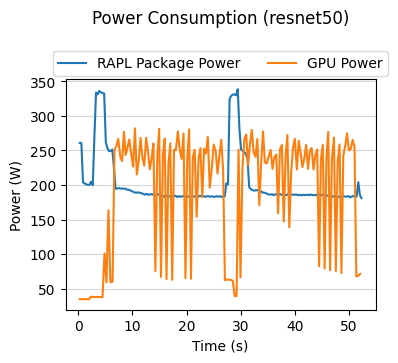

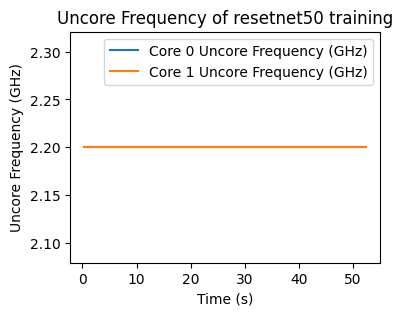

In [8]:
plot_power_CPU_GPU(resnet50_cpu_baseline,resnet50_gpu_baseline,"resnet50")
plot_uncore_freq(resnet50_uncore_baseline)

In [28]:
resnet50_cpu = "./resnet50/dynamic_uncore_freq_scale/resnet50_power_cpu.csv" 
resnet50_gpu = "./resnet50/dynamic_uncore_freq_scale/resnet50_power_gpu.csv" 
resnet50_uncore = "./resnet50/dynamic_uncore_freq_scale/resnet50_uncore_freq.csv" 

resnet50_cpu = "./resnet50/resnet50_power_cpu.csv" 
resnet50_gpu = "./resnet50/resnet50_power_gpu.csv" 
resnet50_uncore = "./resnet50/resnet50_uncore_freq.csv" 

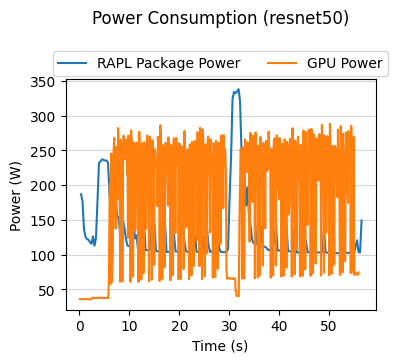

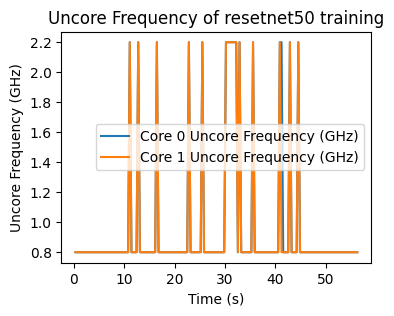

In [25]:
plot_power_CPU_GPU(resnet50_cpu,resnet50_gpu,"resnet50")
plot_uncore_freq(resnet50_uncore)

In [15]:
calculate_energy(resnet50_cpu_baseline, resnet50_gpu_baseline)

Total Energy Consumption: 20609.4 Joules


In [26]:
calculate_energy(resnet50_cpu, resnet50_gpu)

Total Energy Consumption: 17892.03 Joules


In [27]:
# 2.3% performance degradation due to the fact that there is delay 
# to catch the phase change for transfer batch data from DRAM to GPU memory
(20609 - 17892) / 20609

0.13183560580328982